In [7]:
# =========================
# Cell 1: Imports, config, load + CLEAN data
# =========================

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# -------- Load dataset --------
DATA_PATH = "MentalHealthSurvey.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Could not find {DATA_PATH}. Put the CSV next to this notebook or update DATA_PATH."
    )

df = pd.read_csv(DATA_PATH)

print("=== Raw dataset info ===")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nHead:")
print(df.head())

print("\n=== Missing values per column (raw) ===")
print(df.isna().sum())

# =========================
# Cleaning (BEFORE EDA & modeling)
# =========================

print("\n--- Cleaning ---")

# 0) Fix trailing spaces in column names
df.columns = [c.strip() for c in df.columns]

# 1) Strip whitespace in string columns
obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = df[col].astype(str).str.strip()

# 2) Remove duplicate rows
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)
if dup_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Duplicates removed.")
print("Shape after dedup:", df.shape)

# 3) Convert CGPA ranges (e.g., "3.0-3.5") -> numeric midpoint
def cgpa_to_numeric(val):
    if pd.isna(val):
        return np.nan
    if isinstance(val, (int, float)):
        return float(val)
    s = str(val)
    if "-" in s or "–" in s:
        parts = re.split(r"[-–]", s)
        nums = []
        for p in parts:
            p = p.strip()
            if not p:
                continue
            try:
                nums.append(float(p))
            except ValueError:
                pass
        if len(nums) == 2:
            return (nums[0] + nums[1]) / 2.0
    s_clean = re.sub(r"[^0-9.]", "", s)
    try:
        return float(s_clean)
    except ValueError:
        return np.nan

if "cgpa" in df.columns:
    df["cgpa"] = df["cgpa"].apply(cgpa_to_numeric)

# 4) Convert average_sleep ("4-6 hrs") -> numeric hours
def sleep_to_hours(val):
    if pd.isna(val):
        return np.nan
    s = str(val).lower()
    if "-" in s or "–" in s:
        parts = re.split(r"[-–]", s)
        nums = []
        for p in parts:
            p = re.sub(r"[^0-9.]", "", p)
            if p:
                try:
                    nums.append(float(p))
                except ValueError:
                    pass
        if len(nums) == 2:
            return (nums[0] + nums[1]) / 2.0
    s_clean = re.sub(r"[^0-9.]", "", s)
    try:
        return float(s_clean)
    except ValueError:
        return np.nan

if "average_sleep" in df.columns:
    df["average_sleep_hours"] = df["average_sleep"].apply(sleep_to_hours)

# 5) Missing values BEFORE filling
print("\nMissing values BEFORE imputation:")
print(df.isna().sum())

# 6) Simple missing-value handling
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in cat_cols:
    mode = df[col].mode()
    df[col].fillna(mode[0] if not mode.empty else "Unknown", inplace=True)

print("\nMissing values AFTER imputation:")
print(df.isna().sum())

print("\nShape AFTER cleaning + imputation:", df.shape)


=== Raw dataset info ===
Shape: (87, 21)
Columns: ['gender', 'age', 'university', 'degree_level', 'degree_major', 'academic_year', 'cgpa', 'residential_status', 'campus_discrimination', 'sports_engagement', 'average_sleep', 'study_satisfaction', 'academic_workload ', 'academic_pressure', 'financial_concerns', 'social_relationships', 'depression', 'anxiety', 'isolation', 'future_insecurity', 'stress_relief_activities']

Head:
   gender  age university   degree_level      degree_major academic_year  \
0    Male   20         PU  Undergraduate      Data Science      2nd year   
1    Male   20        UET   Postgraduate  Computer Science      3rd year   
2    Male   20       FAST  Undergraduate  Computer Science      3rd year   
3    Male   20        UET  Undergraduate  Computer Science      3rd year   
4  Female   20        UET  Undergraduate  Computer Science      3rd year   

      cgpa residential_status campus_discrimination sports_engagement  ...  \
0  3.0-3.5         Off-Campus       

C:\Users\sishi\AppData\Local\Temp\ipykernel_35268\3291361131.py:136: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\sishi\AppData\Local\Temp\ipykernel_35268\3291361131.py:136: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

=== Descriptive statistics (numeric) ===
             age       cgpa  study_satisfaction  academic_workload  \
count  87.000000  87.000000           87.000000          87.000000   
mean   19.942529   3.011494            3.931034           3.885057   
std     1.623636   0.893214            1.043174           0.854880   
min    17.000000   0.000000            1.000000           2.000000   
25%    19.000000   2.750000            3.000000           3.000000   
50%    20.000000   3.250000            4.000000           4.000000   
75%    21.000000   3.750000            5.000000           4.500000   
max    26.000000   3.750000            5.000000           5.000000   

       academic_pressure  financial_concerns  social_relationships  \
count          87.000000           87.000000             87.000000   
mean            3.781609            3.390805              2.781609   
std             1.125035            1.400634              1.175578   
min             1.000000            1.000000    

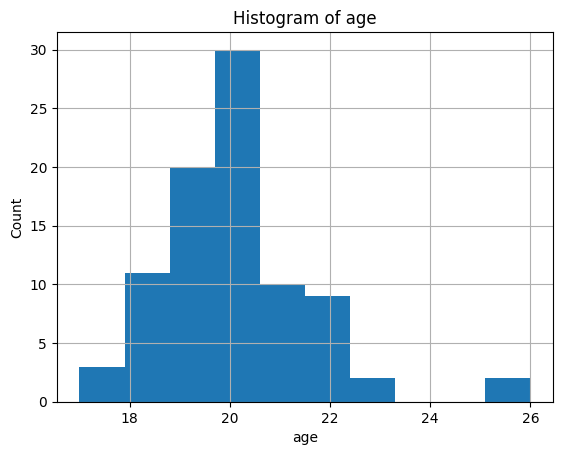

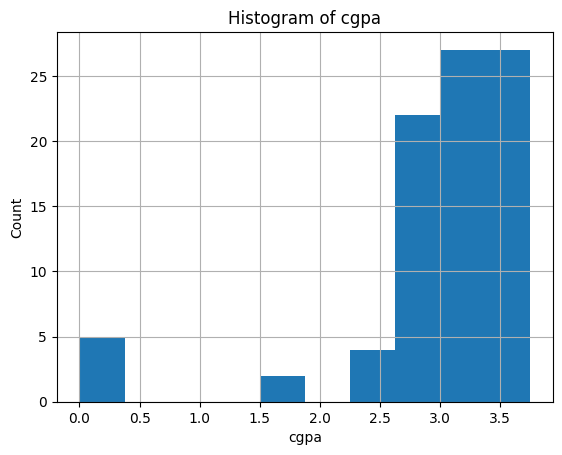

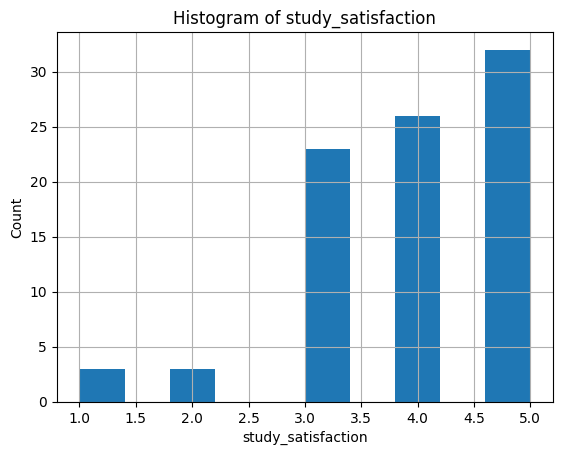

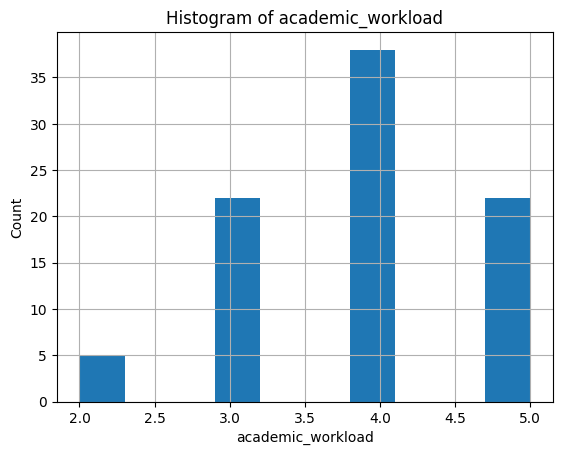

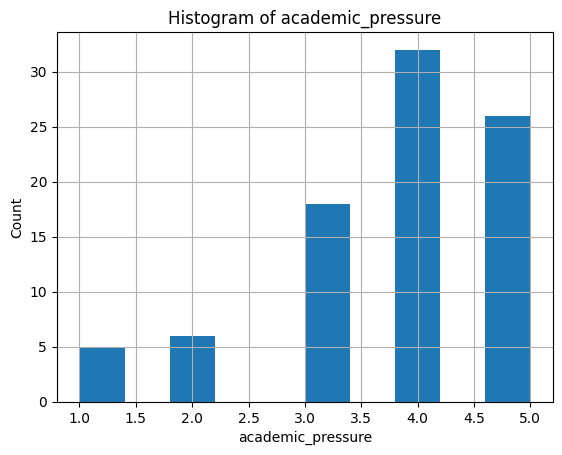

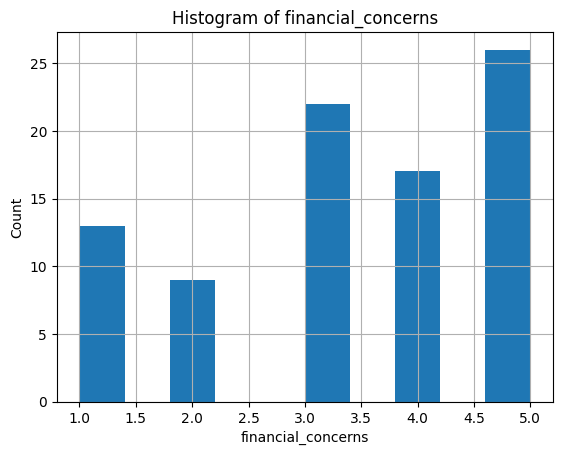

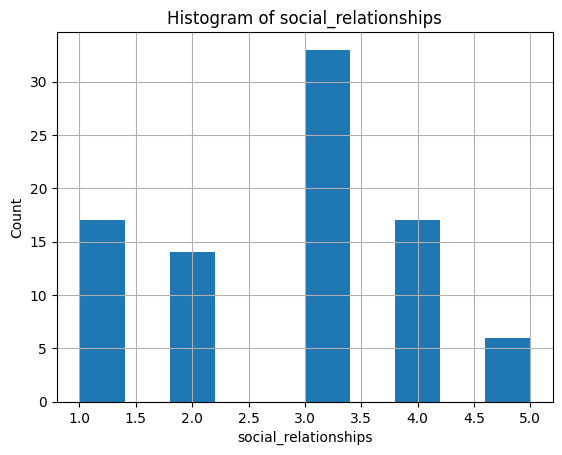

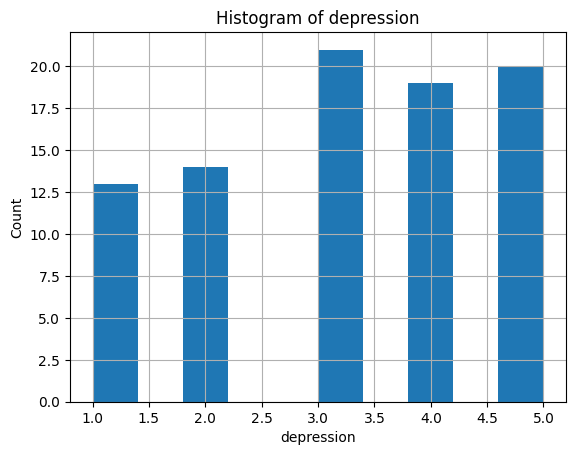

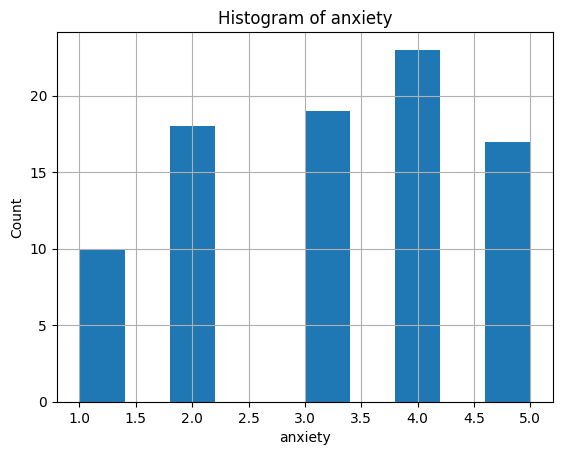

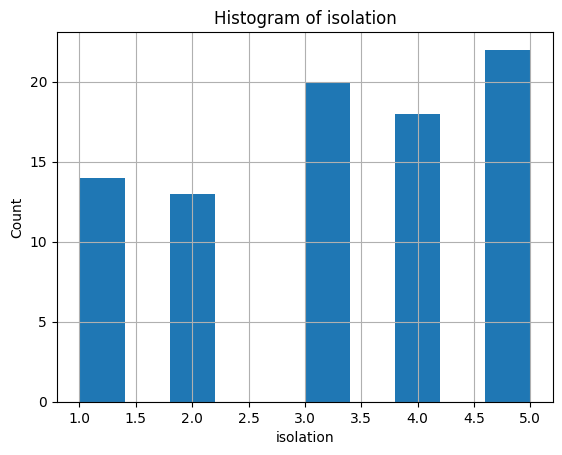

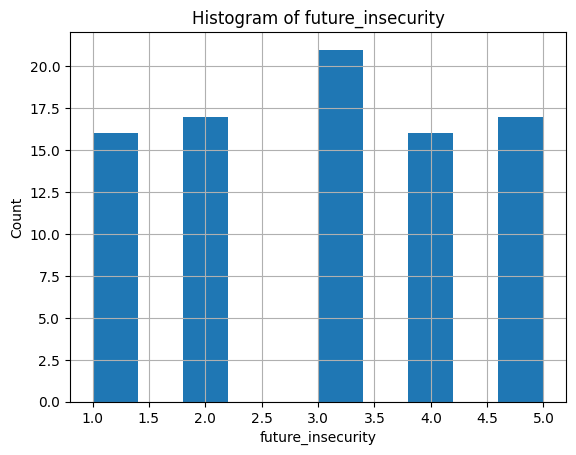

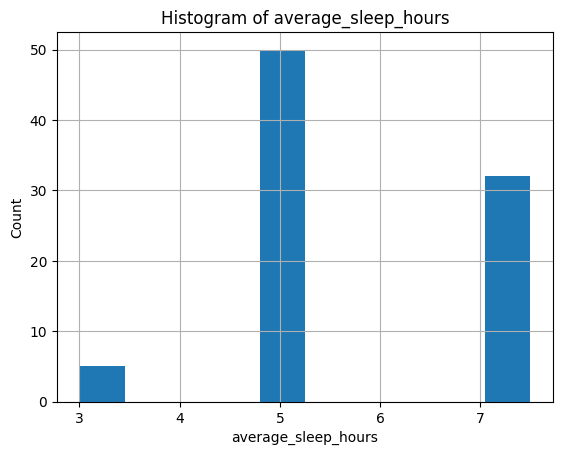

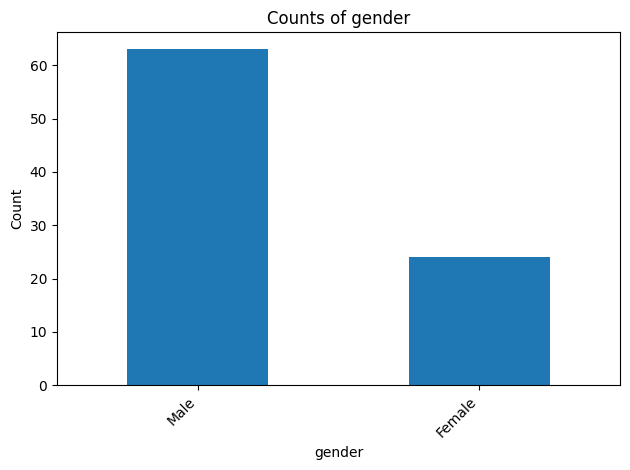

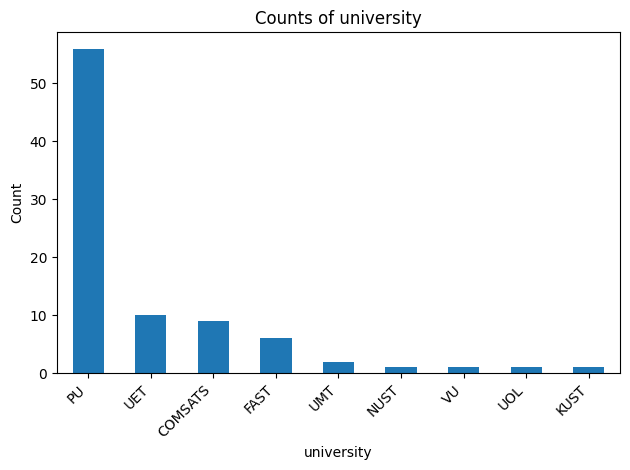

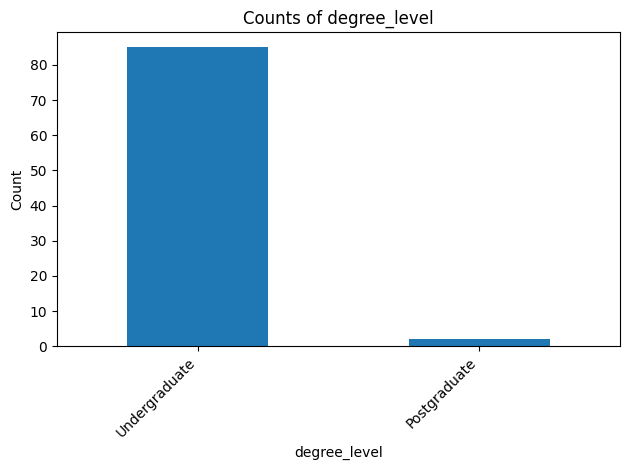

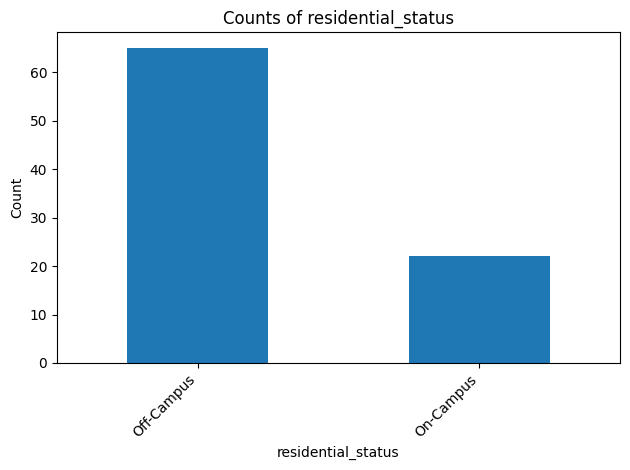

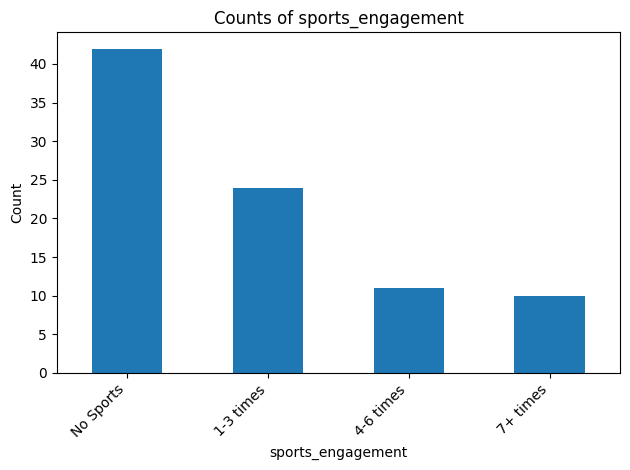

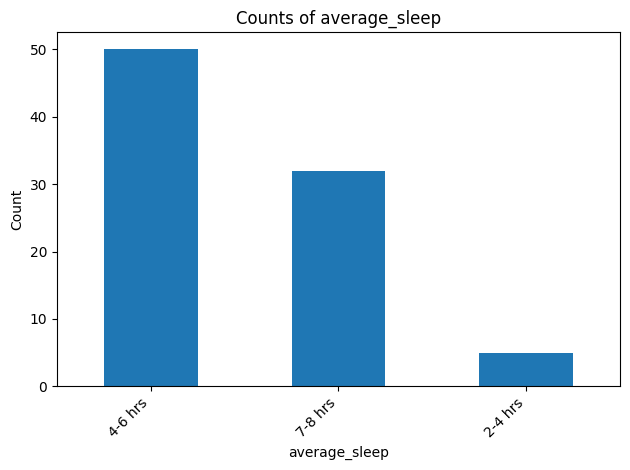

C:\Users\sishi\AppData\Local\Temp\ipykernel_35268\3011434766.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


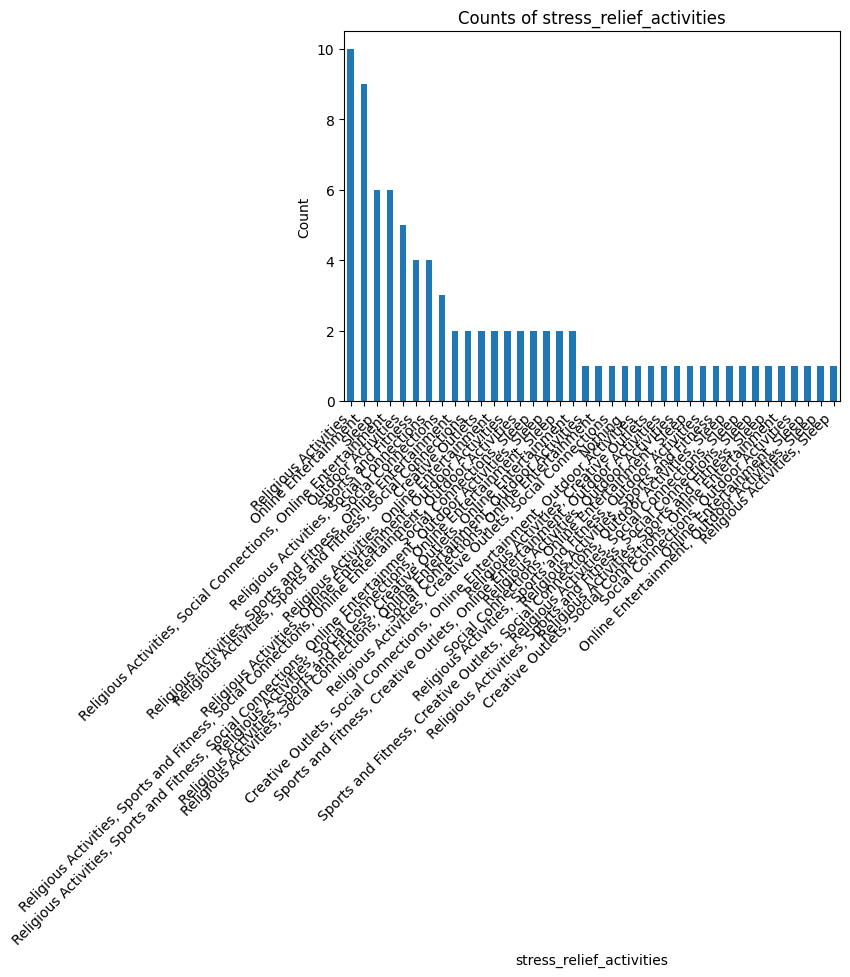

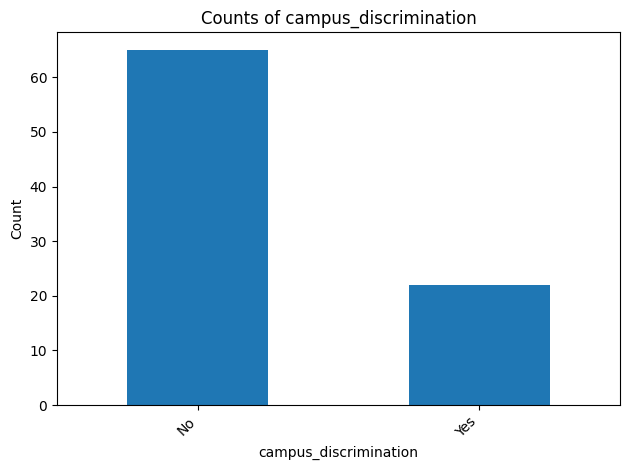

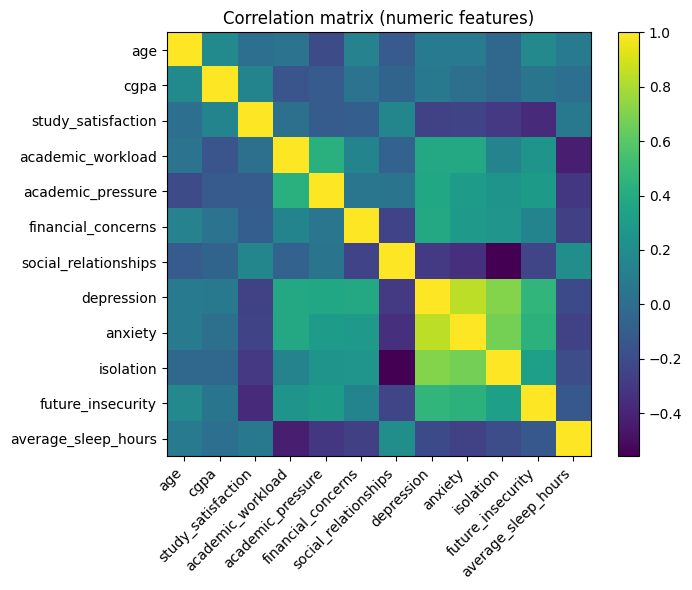


=== Correlation matrix ===
                           age      cgpa  study_satisfaction  \
age                   1.000000  0.180862            0.011363   
cgpa                  0.180862  1.000000            0.147492   
study_satisfaction    0.011363  0.147492            1.000000   
academic_workload     0.037072 -0.146722            0.017085   
academic_pressure    -0.204288 -0.110293           -0.102153   
financial_concerns    0.132707  0.033545           -0.092755   
social_relationships -0.110217 -0.058487            0.158249   
depression            0.089504  0.071692           -0.258286   
anxiety               0.088800  0.017871           -0.237822   
isolation            -0.029515 -0.032334           -0.297775   
future_insecurity     0.176095  0.044536           -0.369635   
average_sleep_hours   0.088370  0.012460            0.071325   

                      academic_workload  academic_pressure  \
age                            0.037072          -0.204288   
cgpa           

In [8]:
# =========================
# Cell 2: EDA (on CLEANED df)
# =========================

print("=== Descriptive statistics (numeric) ===")
print(df.describe(include=[np.number]))

print("\n=== Descriptive statistics (categorical) ===")
print(df.describe(include=["object"]))

# Helper plot functions
def plot_hist(column, bins=10):
    if column not in df.columns:
        return
    plt.figure()
    df[column].dropna().astype(float, errors="ignore").hist(bins=bins)
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

def plot_bar(column):
    if column not in df.columns:
        return
    plt.figure()
    df[column].value_counts().plot(kind="bar")
    plt.title(f"Counts of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Numeric-ish columns
num_like_cols = [
    "age", "cgpa", "study_satisfaction", "academic_workload",
    "academic_pressure", "financial_concerns", "social_relationships",
    "depression", "anxiety", "isolation", "future_insecurity",
    "average_sleep_hours"
]
for col in num_like_cols:
    if col in df.columns:
        plot_hist(col)

# Categorical columns
cat_cols = [
    "gender", "university", "degree_level", "residential_status",
    "sports_engagement", "average_sleep", "stress_relief_activities",
    "campus_discrimination"
]
for col in cat_cols:
    if col in df.columns:
        plot_bar(col)

# Correlation matrix for numeric columns
numeric_cols_raw = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols_raw) > 1:
    plt.figure(figsize=(8, 6))
    corr = df[numeric_cols_raw].corr()
    im = plt.imshow(corr, interpolation="nearest")
    plt.xticks(range(len(numeric_cols_raw)), numeric_cols_raw, rotation=45, ha="right")
    plt.yticks(range(len(numeric_cols_raw)), numeric_cols_raw)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Correlation matrix (numeric features)")
    plt.tight_layout()
    plt.show()
    print("\n=== Correlation matrix ===")
    print(corr)


In [9]:
# =========================
# Cell 3: Target & preprocessing (no sklearn for models)
# =========================

TARGET_COL = "depression"

if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in dataset.")

def make_binary_target(x):
    try:
        x_float = float(x)
    except Exception:
        return np.nan
    return 1 if x_float >= 3 else 0

y = df[TARGET_COL].apply(make_binary_target)
df_model = df[~y.isna()].copy()
y = y[~y.isna()].astype(int).values

print("Target value counts (0=low/moderate, 1=high):")
unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"{u}: {c}")

# Features (drop target)
X = df_model.drop(columns=[TARGET_COL])

# Numeric vs categorical
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

# One-hot encode categoricals using pandas
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=False)

# Manual standardization
X_values = X_encoded.values.astype(float)
feature_means = X_values.mean(axis=0)
feature_stds = X_values.std(axis=0) + 1e-6
X_scaled = (X_values - feature_means) / feature_stds

feature_names = np.array(X_encoded.columns.tolist())
print("\nEncoded feature matrix shape:", X_scaled.shape)

# Train-test split (sklearn here is fine; no model)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train_full.shape, "Test shape:", X_test_full.shape)

# Metric helpers (for all models)
def classification_metrics(y_true, y_pred):
    y_true = np.array(y_true).astype(int).reshape(-1)
    y_pred = np.array(y_pred).astype(int).reshape(-1)

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    precision = tp / (tp + fp + 1e-8) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn + 1e-8) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall + 1e-8)
          if (precision + recall) > 0 else 0.0)

    cm = np.array([[tn, fp],
                   [fn, tp]])
    return accuracy, precision, recall, f1, cm

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


Target value counts (0=low/moderate, 1=high):
0: 27
1: 60

Numeric features: ['age', 'cgpa', 'study_satisfaction', 'academic_workload', 'academic_pressure', 'financial_concerns', 'social_relationships', 'anxiety', 'isolation', 'future_insecurity', 'average_sleep_hours']
Categorical features: ['gender', 'university', 'degree_level', 'degree_major', 'academic_year', 'residential_status', 'campus_discrimination', 'sports_engagement', 'average_sleep', 'stress_relief_activities']

Encoded feature matrix shape: (87, 81)
Train shape: (69, 81) Test shape: (18, 81)


=== Top features by importance (Decision Tree) ===
anxiety: 0.5335
future_insecurity: 0.0918
academic_workload: 0.0803
stress_relief_activities_Online Entertainment, Outdoor Activities, Sleep: 0.0789
social_relationships: 0.0645
financial_concerns: 0.0565


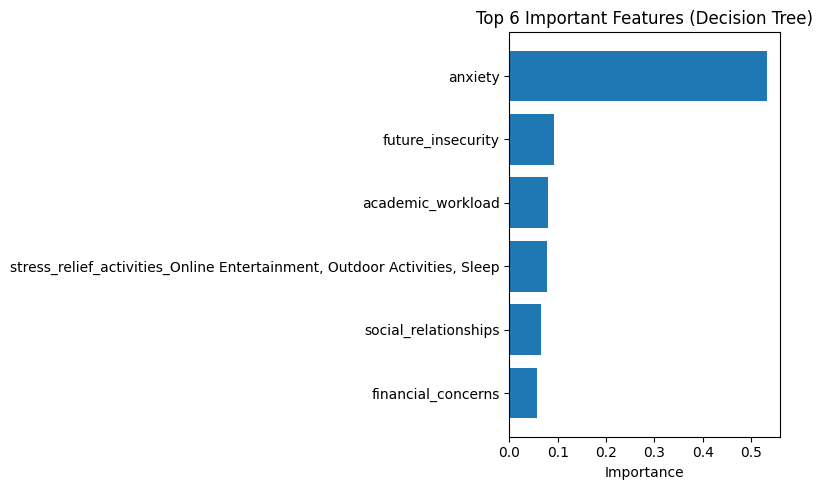


Shape with selected features: (69, 6) (18, 6)
Selected features: [np.str_('anxiety'), np.str_('future_insecurity'), np.str_('academic_workload'), np.str_('stress_relief_activities_Online Entertainment, Outdoor Activities, Sleep'), np.str_('social_relationships'), np.str_('financial_concerns')]


In [10]:
# =========================
# Cell 4: Feature importance (Decision Tree) + select top features
# =========================

# Train a shallow Decision Tree to estimate feature importance
tree = DecisionTreeClassifier(
    max_depth=4,
    random_state=RANDOM_STATE,
    class_weight="balanced"
)
tree.fit(X_train_full, y_train)

importances = tree.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

# Choose top K most important features (you can change K)
TOP_K = 6
top_idx = sorted_idx[:TOP_K]
top_feature_names = feature_names[top_idx]

print("=== Top features by importance (Decision Tree) ===")
for name, imp in zip(top_feature_names, importances[top_idx]):
    print(f"{name}: {imp:.4f}")

# Bar plot of top features
plt.figure(figsize=(8, 5))
plt.barh(range(TOP_K), importances[top_idx][::-1])
plt.yticks(range(TOP_K), top_feature_names[::-1])
plt.title(f"Top {TOP_K} Important Features (Decision Tree)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Reduce X to only selected features
X_train = X_train_full[:, top_idx]
X_test  = X_test_full[:, top_idx]

print("\nShape with selected features:", X_train.shape, X_test.shape)
print("Selected features:", list(top_feature_names))

# Torch tensors for reduced-feature models
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32).view(-1, 1)

input_dim = X_train.shape[1]


LogisticRegression Epoch 50/300, best F1 so far: 0.9091


C:\Users\sishi\AppData\Local\Temp\ipykernel_35268\482097964.py:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_true = np.array(y_true).astype(int).reshape(-1)


LogisticRegression Epoch 100/300, best F1 so far: 0.9565
LogisticRegression Epoch 150/300, best F1 so far: 0.9565
LogisticRegression Epoch 200/300, best F1 so far: 0.9565
LogisticRegression Epoch 250/300, best F1 so far: 0.9565
LogisticRegression Epoch 300/300, best F1 so far: 0.9565

=== Logistic Regression (PyTorch, selected features) ===
Accuracy : 0.944444443919753
Precision: 0.999999999090909
Recall   : 0.9166666659027777
F1-score : 0.9565217333081286
Confusion matrix:
 [[ 6  0]
 [ 1 11]]


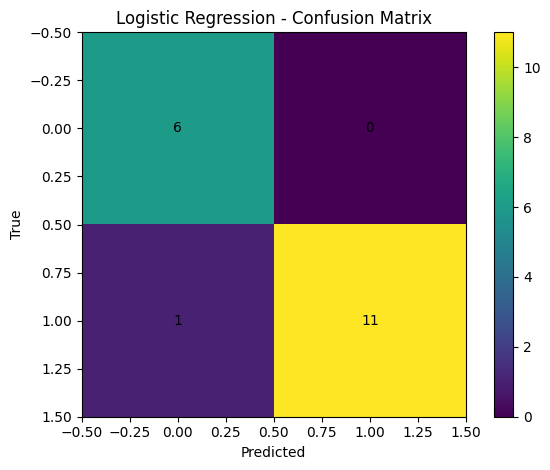

NeuralNetwork Epoch 50/500, best F1 so far: 0.9565
NeuralNetwork Epoch 100/500, best F1 so far: 0.9565
NeuralNetwork Epoch 150/500, best F1 so far: 1.0000
NeuralNetwork Epoch 200/500, best F1 so far: 1.0000
NeuralNetwork Epoch 250/500, best F1 so far: 1.0000
NeuralNetwork Epoch 300/500, best F1 so far: 1.0000
NeuralNetwork Epoch 350/500, best F1 so far: 1.0000
NeuralNetwork Epoch 400/500, best F1 so far: 1.0000
NeuralNetwork Epoch 450/500, best F1 so far: 1.0000
NeuralNetwork Epoch 500/500, best F1 so far: 1.0000

=== Neural Network (MLP, PyTorch, selected features) ===
Accuracy : 0.9999999994444444
Precision: 0.9999999991666666
Recall   : 0.9999999991666666
F1-score : 0.9999999941666666
Confusion matrix:
 [[ 6  0]
 [ 0 12]]


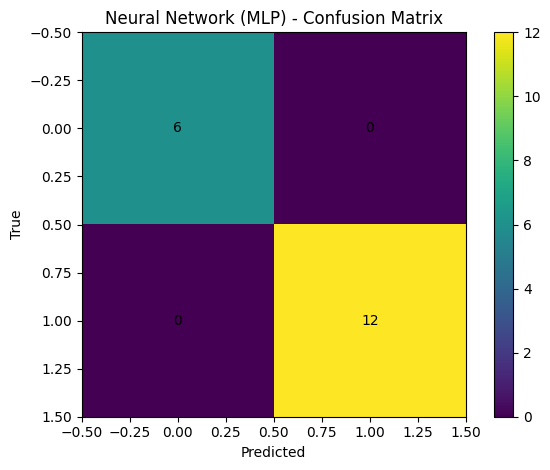


=== PyTorch Model Comparison (Selected Features) ===
LogReg -> acc=0.9444, prec=1.0000, rec=0.9167, f1=0.9565
MLP    -> acc=1.0000, prec=1.0000, rec=1.0000, f1=1.0000
Best PyTorch model based on F1: MLP

Error rates and STD (PyTorch models):
LogReg error rate: 0.05555555555555555 STD: 0.2290614236454256
MLP    error rate: 0.0 STD: 0.0


In [11]:
# =========================
# Cell 5: PyTorch Logistic Regression + Neural Network on SELECTED FEATURES
# =========================

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)  # logits

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=(64, 32), dropout=0.1):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def train_torch_model(model, X_train, y_train, X_val, y_val,
                      lr=1e-3, epochs=300, batch_size=16,
                      weight_decay=1e-4, verbose=False, name="model"):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    n = X_train.shape[0]
    best_f1 = -1.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(n)
        for i in range(0, n, batch_size):
            idx = perm[i:i+batch_size]
            bx = X_train[idx]
            by = y_train[idx]

            optimizer.zero_grad()
            logits = model(bx)
            loss = criterion(logits, by)
            loss.backward()
            optimizer.step()

        # val F1 tracking
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val)
            probs = torch.sigmoid(val_logits).cpu().numpy().flatten()
            y_val_pred = (probs >= 0.5).astype(int)
            _, _, _, f1, _ = classification_metrics(y_val, y_val_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if verbose and (epoch + 1) % 50 == 0:
            print(f"{name} Epoch {epoch+1}/{epochs}, best F1 so far: {best_f1:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    return model

# ---- Train Logistic Regression (PyTorch) ----
log_reg_model = LogisticRegressionModel(input_dim)
log_reg_model = train_torch_model(
    log_reg_model,
    X_train_t, y_train_t,
    X_test_t,  y_test_t,
    lr=1e-3, epochs=300, batch_size=8,
    name="LogisticRegression", verbose=True
)

log_reg_model.eval()
with torch.no_grad():
    logits_lr = log_reg_model(X_test_t)
    probs_lr = torch.sigmoid(logits_lr).cpu().numpy().flatten()
    y_pred_lr = (probs_lr >= 0.5).astype(int)

acc_lr, prec_lr, rec_lr, f1_lr, cm_lr = classification_metrics(y_test, y_pred_lr)
print("\n=== Logistic Regression (PyTorch, selected features) ===")
print("Accuracy :", acc_lr)
print("Precision:", prec_lr)
print("Recall   :", rec_lr)
print("F1-score :", f1_lr)
print("Confusion matrix:\n", cm_lr)
plot_confusion_matrix(cm_lr, "Logistic Regression - Confusion Matrix")

# ---- Train Neural Network (PyTorch) ----
mlp_model = MLPClassifier(input_dim=input_dim, hidden_dims=(64, 32), dropout=0.1)
mlp_model = train_torch_model(
    mlp_model,
    X_train_t, y_train_t,
    X_test_t,  y_test_t,
    lr=1e-3, epochs=500, batch_size=8,
    name="NeuralNetwork", verbose=True
)

mlp_model.eval()
with torch.no_grad():
    logits_mlp = mlp_model(X_test_t)
    probs_mlp = torch.sigmoid(logits_mlp).cpu().numpy().flatten()
    y_pred_mlp = (probs_mlp >= 0.5).astype(int)

acc_mlp, prec_mlp, rec_mlp, f1_mlp, cm_mlp = classification_metrics(y_test, y_pred_mlp)
print("\n=== Neural Network (MLP, PyTorch, selected features) ===")
print("Accuracy :", acc_mlp)
print("Precision:", prec_mlp)
print("Recall   :", rec_mlp)
print("F1-score :", f1_mlp)
print("Confusion matrix:\n", cm_mlp)
plot_confusion_matrix(cm_mlp, "Neural Network (MLP) - Confusion Matrix")

print("\n=== PyTorch Model Comparison (Selected Features) ===")
print(f"LogReg -> acc={acc_lr:.4f}, prec={prec_lr:.4f}, rec={rec_lr:.4f}, f1={f1_lr:.4f}")
print(f"MLP    -> acc={acc_mlp:.4f}, prec={prec_mlp:.4f}, rec={rec_mlp:.4f}, f1={f1_mlp:.4f}")
best_pytorch = "MLP" if f1_mlp >= f1_lr else "Logistic Regression"
print("Best PyTorch model based on F1:", best_pytorch)

# Error stats
lr_errors = np.abs(y_test - y_pred_lr)
mlp_errors = np.abs(y_test - y_pred_mlp)
print("\nError rates and STD (PyTorch models):")
print("LogReg error rate:", lr_errors.mean(), "STD:", lr_errors.std())
print("MLP    error rate:", mlp_errors.mean(), "STD:", mlp_errors.std())


=== 5-Fold Cross-Validated Sklearn Model Performance (Selected Features) ===
       Model  Accuracy_mean  Accuracy_std  Precision_mean  Recall_mean  F1_mean   F1_std
RandomForest       0.884314      0.083691        0.925275     0.916667 0.912615 0.068901
   SVM (RBF)       0.849673      0.071955        0.950000     0.833333 0.879187 0.071233
   KNN (k=5)       0.850327      0.047240        0.898095     0.900000 0.889060 0.046072


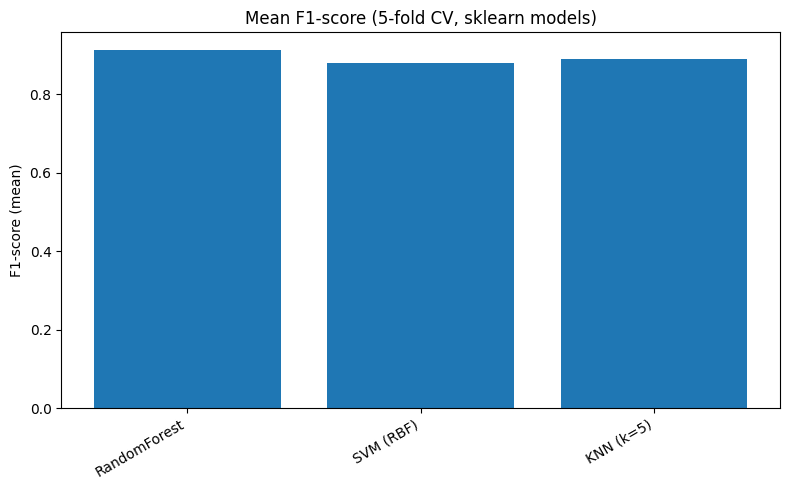

In [13]:
# =========================
# NEW: Cross-validated sklearn model comparison (Selected Features)
# =========================

from sklearn.model_selection import StratifiedKFold

X_for_models = X_scaled[:, top_idx]  # same selected features
y_for_models = y

sk_models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE,
        class_weight="balanced"
    ),
    "SVM (RBF)": SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = []

for name, model in sk_models.items():
    accs, precs, recs, f1s = [], [], [], []

    for train_idx, test_idx in kfold.split(X_for_models, y_for_models):
        X_tr, X_te = X_for_models[train_idx], X_for_models[test_idx]
        y_tr, y_te = y_for_models[train_idx], y_for_models[test_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

        accs.append(accuracy_score(y_te, y_pred))
        precs.append(precision_score(y_te, y_pred, zero_division=0))
        recs.append(recall_score(y_te, y_pred, zero_division=0))
        f1s.append(f1_score(y_te, y_pred, zero_division=0))

    cv_results.append({
        "Model": name,
        "Accuracy_mean":  np.mean(accs),
        "Accuracy_std":   np.std(accs),
        "Precision_mean": np.mean(precs),
        "Recall_mean":    np.mean(recs),
        "F1_mean":        np.mean(f1s),
        "F1_std":         np.std(f1s),
    })

cv_df = pd.DataFrame(cv_results)
print("=== 5-Fold Cross-Validated Sklearn Model Performance (Selected Features) ===")
print(cv_df.to_string(index=False))

# Bar chart of mean F1-scores
plt.figure(figsize=(8, 5))
plt.bar(cv_df["Model"], cv_df["F1_mean"])
plt.title("Mean F1-score (5-fold CV, sklearn models)")
plt.ylabel("F1-score (mean)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()
